In [1]:
import time
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [4]:
import gym
import numpy as np
from gym import spaces, utils
from MAMEToolkit.emulator import Emulator
from MAMEToolkit.emulator import Address
from KofSteps import *
from KofActions import Actions
import cv2
import math
import random
import string
from typing import Any, Dict
import pandas as pd
import gym
import numpy as np
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from Kof97EnvironmentSR import Kof98EnvironmentLSTM
from Kof97EnvironmentSR import Kof98EnvironmentV2

In [1]:
from Kof97EnvironmentSR import Kof98EnvironmentLSTM
from Kof97EnvironmentSR import Kof98EnvironmentV2

/home/duhuaiyu/anaconda3/envs/torch37cuda11/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
roms_path = "roms/"
# env = Kof98EnvironmentV2(roms_path=roms_path, CH="CH0")
# env_CH2 = Kof98EnvironmentV2(roms_path=roms_path, CH="CH2")
# env_CH16 = Kof98EnvironmentV2(roms_path=roms_path, CH="CH16")
# env_CH26 = Kof98EnvironmentV2(roms_path=roms_path, CH="CH26")
lstm_env = Kof98EnvironmentLSTM(roms_path=roms_path, CH="CH0")

env_id:NC439BY78NWUMN2


unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB
unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB
unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB
unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB


b'\x1b[MAME]\x1b> nil\n'
b'\x1b[MAME]\x1b> sol.lua_engine::addr_space: 0xd73ce18\n'
b'\x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> RGB32 - 32bpp 8-8-8 RGB\n'
b'\x1b[MAME]\x1b> 320\n'
b'\x1b[MAME]\x1b> 224\n'


In [5]:

static_info = []
static_info_meanrward = []
combo_df = pd.DataFrame(columns=["category", "combo","count"])
ACT_df = pd.DataFrame(columns=["category", "ACT","count"])

models = {
    # "Multi CNN VS Kyo Kusanagi" : {"model":'Kof97_PPO_V2_t3_1', "env":env},
    # "Multi CNN VS Goro Daimon" : {"model":'Kof97_PPO_V2_t3_1_Transfer_CH2_2', "env":env_CH2},
    # "Multi CNN VS Mai Shiranui" : {"model":'Kof97_PPO_V2_t3_1_transfer_CH16', "env":env_CH16},
    # "Multi CNN VS Billy" : {"model":'Kof97_PPO_V2_t3_1_transfer_CH26', "env":env_CH26},
    "LSTM VS Kyo Kusanagi 786 units" : {"model":'Kof97_PPO_LSTM_layer1_768_3', "env":lstm_env},
}
_n_eval_episodes = 50
for key,value in models.items():
    print("============",key)
    print(value)
    model_name = value["model"]
    env_local = value["env"]
    print(model_name)
    if key.startswith("LSTM"):
        model = RecurrentPPO.load(model_name, env=env_local)

    else:
        model = PPO.load(model_name, env=env_local)
    df = pd.DataFrame()
    combos={i: 0 for i in range(2,13)}
    ACTs={i: 0 for i in range(0,512)}
    def eval_callback(_locals: Dict[str, Any], _globals: Dict[str, Any]) -> None:
        """
        Renders the environment in its current state, recording the screen in the captured `screens` list

        :param _locals: A dictionary containing all local variables of the callback's scope
        :param _globals: A dictionary containing all global variables of the callback's scope
        """
        # statistic combos
        combo_num = _locals["info"]["2P_combo"]
        act_1p = _locals["info"]["1P_Action"]
        ACTs[act_1p] += 1
        if combo_num == 0 and _globals.get("combo_num") is not None and _globals.get("combo_num") > 0:
            combos[_globals.get("combo_num")] +=1
        _globals["combo_num"] = combo_num
        current_episode = _locals["episode_counts"][0]
        # statistic win_loss
        if _locals["dones"][0]:
            print(_locals["info"].get("win_loss") )
            print(_locals["info"].get("time"))
            hex_time = _locals["info"].get("time")
            ten_place, one_place = divmod(hex_time,16)
            time = ten_place*10 + one_place
            print(time)

            static_info.append([key,current_episode,_locals["info"].get("win_loss"),time,_locals["info"].get("healthP1")])

    mean_reward, std_reward = evaluate_policy(
            model,
            env_local,
            callback=eval_callback,
            n_eval_episodes=_n_eval_episodes,
            deterministic=False,
            return_episode_rewards=False)
    static_info_meanrward.append([key,mean_reward, std_reward])
    combo_df_temp = pd.DataFrame(combos.items(),columns=["combo","count"])
    combo_df_temp["category"] = key
    combo_df = combo_df.append(combo_df_temp)
    act_df_temp = pd.DataFrame(ACTs.items(),columns=["ACT","count"])
    act_df_temp["category"] = key
    ACT_df = ACT_df.append(act_df_temp)
    # print(static_info)
    # print(ACTs)
    # print(combos)



============ LSTM VS Kyo Kusanagi 786 units
{'model': 'Kof97_PPO_LSTM_layer1_768_3', 'env': <Kof97EnvironmentSR.Kof98EnvironmentLSTM object at 0x7fafb1e52550>}
Kof97_PPO_LSTM_layer1_768_3


/home/duhuaiyu/anaconda3/envs/torch37cuda11/lib/python3.7/site-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


WIN
36
24
LOSE
66
42
LOSE
24
18
WIN
37
25
LOSE
41
29
WIN
38
26
LOSE
25
19
LOSE
55
37
WIN
38
26
WIN
50
32
LOSE
0
0
LOSE
56
38
WIN
35
23
WIN
53
35
LOSE
49
31
LOSE
41
29
WIN
20
14
LOSE
53
35
LOSE
39
27
LOSE
40
28
WIN
52
34
WIN
32
20
WIN
38
26
LOSE
39
27
LOSE
54
36
LOSE
34
22
WIN
25
19
WIN
39
27
LOSE
36
24
WIN
39
27
LOSE
37
25
LOSE
41
29
WIN
49
31
LOSE
52
34
LOSE
55
37
LOSE
37
25
LOSE
53
35
WIN
48
30
WIN
50
32
WIN
38
26
WIN
48
30
LOSE
49
31
LOSE
57
39
LOSE
56
38
WIN
52
34
WIN
49
31
WIN
51
33
LOSE
19
13
LOSE
40
28
WIN
36
24


In [6]:
print(static_info)

[['LSTM VS Kyo Kusanagi 786 units', 0, 'WIN', 24, 19], ['LSTM VS Kyo Kusanagi 786 units', 1, 'LOSE', 42, -9], ['LSTM VS Kyo Kusanagi 786 units', 2, 'LOSE', 18, -5], ['LSTM VS Kyo Kusanagi 786 units', 3, 'WIN', 25, 40], ['LSTM VS Kyo Kusanagi 786 units', 4, 'LOSE', 29, -3], ['LSTM VS Kyo Kusanagi 786 units', 5, 'WIN', 26, 43], ['LSTM VS Kyo Kusanagi 786 units', 6, 'LOSE', 19, -6], ['LSTM VS Kyo Kusanagi 786 units', 7, 'LOSE', 37, -4], ['LSTM VS Kyo Kusanagi 786 units', 8, 'WIN', 26, 70], ['LSTM VS Kyo Kusanagi 786 units', 9, 'WIN', 32, 28], ['LSTM VS Kyo Kusanagi 786 units', 10, 'LOSE', 0, -2], ['LSTM VS Kyo Kusanagi 786 units', 11, 'LOSE', 38, -7], ['LSTM VS Kyo Kusanagi 786 units', 12, 'WIN', 23, 4], ['LSTM VS Kyo Kusanagi 786 units', 13, 'WIN', 35, 85], ['LSTM VS Kyo Kusanagi 786 units', 14, 'LOSE', 31, -2], ['LSTM VS Kyo Kusanagi 786 units', 15, 'LOSE', 29, -7], ['LSTM VS Kyo Kusanagi 786 units', 16, 'WIN', 14, 1], ['LSTM VS Kyo Kusanagi 786 units', 17, 'LOSE', 35, -2], ['LSTM VS Ky

In [3]:
#model = PPO.load("Kof97_PPO_V2_t3_1")

print(model.policy)

MultiInputActorCriticPolicy(
  (features_extractor): CombinedExtractor(
    (extractors): ModuleDict(
      (act_1p): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=3840, out_features=256, bias=True)
          (1): ReLU()
        )
      )
      (act_2p): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear

In [3]:
rmodel=RecurrentPPO.load("Kof97_PPO_LSTM_layer2_2048_2")
print(rmodel.policy)

RecurrentActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=2048, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=2048, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=49, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
  (lstm_actor): LSTM(1093, 2048, num_layers=2)
)


In [50]:
import matplotlib.pyplot as plt
import time
import statistics

#matplotlib inline
plt.ion()
from IPython import display
obs = env.reset()
max_round = 50
current_episode = 0
rewards = []
combos={i: 0 for i in range(2,13)}
ACTs={i: 0 for i in range(0,512)}
golbal_dict = {"last_combo_num" : 0 }
global_reward = 0
key = "Random Agent"

def eval_callback2(info,golbal,dones,reward) -> None:
    """
    Renders the environment in its current state, recording the screen in the captured `screens` list

    :param _locals: A dictionary containing all local variables of the callback's scope
    :param _globals: A dictionary containing all global variables of the callback's scope
    """
    # statistic combos
    combo_num = info["2P_combo"]
    act_1p = info["1P_Action"]
    ACTs[act_1p] += 1
    if combo_num == 0 and golbal["last_combo_num"] is not None and golbal["last_combo_num"] > 0:
        combos[golbal["last_combo_num"]] +=1
    golbal["last_combo_num"] = combo_num
    global global_reward
    global_reward += reward

    # statistic win_loss
    if dones:
        hex_time = info.get("time")
        ten_place, one_place = divmod(hex_time,16)
        time = ten_place*10 + one_place
        print(time)
        rewards.append(global_reward)
        global_reward = 0
        static_info.append([key,current_episode,info.get("win_loss"),time,max(0,info.get("healthP1"))])
for _ in range(100000000):
    display.clear_output(wait=True)
    action = env.action_space.sample()
    #action, _states = model.predict(obs, deterministic=True)
    # print(f"action: {action}")

    observation, reward,done, info =env.step(action) # take a random action
    eval_callback2(info,golbal_dict,done,reward)
    #observation, reward,done, info =env.step(0)
    # plt.imshow(img)
    # plt.pause(0.1)
    # plt.clf()

    # cv2.waitKey(0)

    if done:
        current_episode +=1
        env.reset()
        if current_episode>=max_round:
            break
#env.close()
static_info_meanrward.append([key,statistics.mean(rewards), statistics.stdev(rewards)])
combo_df_temp = pd.DataFrame(combos.items(),columns=["combo","count"])
combo_df_temp["category"] = key
combo_df = combo_df.append(combo_df_temp)
act_df_temp = pd.DataFrame(ACTs.items(),columns=["ACT","count"])
act_df_temp["category"] = key
ACT_df = ACT_df.append(act_df_temp)

29


In [7]:
static_info_df = pd.DataFrame(static_info,columns=["category", "episode","WinLoss","Time","Health"])
static_info_meanrward_df = pd.DataFrame(static_info_meanrward,columns=["category", "mean reward","std reward"])
static_info_df.to_csv("data/static_info_df.csv" , mode='a', index=False, header=False)
static_info_meanrward_df.to_csv("data/static_info_meanrward_df.csv", mode='a', index=False, header=False)
combo_df.to_csv("data/combo_df.csv", mode='a', index=False, header=False)
ACT_df.to_csv("data/ACT_df.csv", mode='a', index=False, header=False)

1P act:37, health: 78, loc:(44,0), energy 20, reward:-0.01
2P act:1, health: 103, loc:(148,0), energy 0 ,toward:0


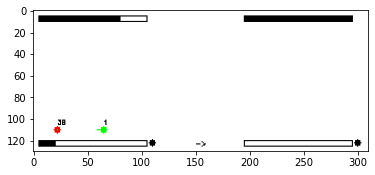

b'\x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[M

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import time
#matplotlib inline
plt.ion()
from IPython import display
#obs = env.reset()
# for i in range(5000):
#     action, _states = model.predict(obs, deterministic=True)
#     obs, rewards, dones, info = env.step(action)
#     if dones:
#         env.reset()
obs = env.reset()
for _ in range(1000):
    display.clear_output(wait=True)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.2
    img = env.render()
    #cv2.imshow("env",img)
    # action = env.action_space.sample()
    action, _states = model.predict(obs, deterministic=True)
    # print(f"action: {action}")

    observation, reward,done, info =env.step(action) # take a random action
    #observation, reward,done, info =env.step(0)
    plt.imshow(img)
    plt.pause(0.1)
    plt.clf()

    # cv2.waitKey(0)
    if done:
        env.reset()
env.close()


In [56]:
import matplotlib.pyplot as plt
import time
#matplotlib inline
plt.ion()
from IPython import display
for _ in range(1000):
    # display.clear_output(wait=True)
    # font = cv2.FONT_HERSHEY_SIMPLEX
    # fontScale = 0.2

    #cv2.imshow("env",img)
    action = env.action_space.sample()
    # print(f"action: {action}")
    observation, reward,done, info =env.step(env.action_space.sample()) # take a random action
    if info["2P_combo"] > 0:
        print("1111111111111111111111111111111111111111111111111111111111111111111111111")
        env.render("other")
    #observation, reward,done, info =env.step(0)
    # plt.imshow(img)
    # plt.pause(0.1)
    # plt.clf()

    # cv2.waitKey(0)
    if done:
        env.reset()
env.close()

0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 5 5
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944

In [111]:
def int_to_b_array(value):
    return [int(x) for x in bin(value)[2:].zfill(8)]
res = []
for i in range(4,0,-1):
    action_seq = info["action_seq_"+str(i)]
    print(hex(action_seq))
    for _ in range(0,8):
        res.append(action_seq%64)
        action_seq = action_seq >>8
        #print(hex(action_seq))
print(res)
print(len(res))
binary_res = []
last_action = None
same_count = 0
keeped_count = 0
for action in res:
    if keeped_count>=12:
        break
    if action == last_action and same_count<=2:
        same_count +=1
    else:
        binary_res.append(int_to_b_array(action))
        same_count = 0
        keeped_count += 1
    last_action = action
#binary_res.reverse()
for i in range(len(binary_res),12):
    binary_res.append([0,0,0,0,0,0,0,0])
print(binary_res)
print(len(binary_res))
r= np.array(binary_res).flat
print(list(r))
print(len(r))
obs = [1 ,2 ,3]
obs = np.append(obs,r)
print(obs)

0x2101050012004000
0x2505050426044501
-0x7f7f79fbcbfb79fc
0x1400410119000600
[0, 0, 0, 18, 0, 5, 1, 33, 1, 5, 4, 38, 4, 5, 5, 37, 4, 6, 4, 52, 4, 6, 0, 0, 0, 6, 0, 25, 1, 1, 0, 20]
32
[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1]]
12
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
96
[1 2 3 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0
 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1]


In [134]:
from stable_baselines3.common.env_checker import check_env

# It will check your custom environment and output additional warnings if needed
check_env(env)

In [17]:
print(env.action_space)

Discrete(49)


In [16]:
  # delete trained model to demonstrate loading

# Load the trained agent
# NOTE: if you have loading issue, you can pass `print_system_info=True`
# to compare the system on which the model was trained vs the current one
# model = DQN.load("dqn_lunar", env=env, print_system_info=True)
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
model = PPO.load("Kof97_CH0_1", env=env)

# Evaluate the agent
# NOTE: If you use wrappers with your environment that modify rewards,
#       this will be reflected here. To evaluate with original rewards,
#       wrap environment in a "Monitor" wrapper before other wrappers.
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=3)

# Enjoy trained agent
#obs = env.reset()
# for i in range(5000):
#     action, _states = model.predict(obs, deterministic=True)
#     obs, rewards, dones, info = env.step(action)
#     if dones:
#         env.reset()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
2 2.718281828459045 4 10.87312731383618

In [18]:
for i in range(5000):
    action, _states = model.predict(obs, deterministic=False)
    obs, rewards, dones, info = env.step(action)
    if dones:
        env.reset()

0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944117144233 0 0
0 0.36787944

In [9]:
print(mean_reward, std_reward)

53.363 9.591000000000001


In [61]:
import sys
sys.modules[__name__]
try:
  gym.envs.register(
      id='kof97',
      entry_point='__main__:Kof98Environment',
      max_episode_steps=6000000
  )
except:
    pass

In [23]:
from typing import Any, Dict

import gym
import torch as th
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import Video
from stable_baselines3.common.logger import TensorBoardOutputFormat
from datetime import datetime
import matplotlib.pyplot as plt
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO
from stable_baselines3.common.logger import Figure
win_episodes = []
_n_eval_episodes = 50
combos={i: 0 for i in range(2,13)}
env = Kof98EnvironmentLSTM()
obs = env.reset()
#model_name = "Kof97_CH0_1"
#model_name = "Kof97_PPO_P1"
#model_name = "Kof97_1500000_2022-04-30"
model_name = "Kof97_PPO_LSTM_V4"
model = RecurrentPPO.load(model_name, env=env)
print(model.policy)

env_id:LEQWAKGYD8U7NCG


unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB
unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB
unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB
unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB


b'\x1b[MAME]\x1b> nil\n'
b'\x1b[MAME]\x1b> sol.lua_engine::addr_space: 0xd71b258\n'
b'\x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> RGB32 - 32bpp 8-8-8 RGB\n'
b'\x1b[MAME]\x1b> 320\n'
b'\x1b[MAME]\x1b> 224\n'
RecurrentActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=512, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=512, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=49, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
  (lstm_actor): LSTM(1093, 512, num_layers

In [5]:
roms_path = "roms/"
params={
    "throttle":True,
    "sound":False
}
#env.close()
env = Kof98EnvironmentV2(roms_path=roms_path, CH="CH26",env_param=params)
print(env.action_space)
print(env.observation_space)
#env = Kof98EnvironmentLSTM(roms_path=roms_path, CH="CH0",env_param=params)

env_id:R9X84O02BHJ51E3


unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB
unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB
unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB
unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB


b'\x1b[MAME]\x1b> nil\n'
b'\x1b[MAME]\x1b> sol.lua_engine::addr_space: 0xe1ab6a8\n'
b'\x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> RGB32 - 32bpp 8-8-8 RGB\n'
b'\x1b[MAME]\x1b> 320\n'
b'\x1b[MAME]\x1b> 224\n'
Discrete(49)
Dict(act_1p:Box([[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]], [[[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 ...

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]], (36, 512, 1), uint8), act_2p:Box([[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
 

In [7]:
round = 2

current_round = 0
reset_delay = 60
#model = PPO.load("Kof97_PPO_V2_t3_1_transfer_CH26", env=env)
model = RecurrentPPO.load("Kof97_PPO_LSTM_V3", env=env)
obs = env.reset()
while current_round < round:
    action, _state = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        for i in range(0,reset_delay):
            obs, reward, done, info = env.step(0)
        obs = env.reset()
        current_round+=1
##env.close()

In [4]:

from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
video_folder = 'logs/videos/'
video_length = 100
roms_path = "roms/"


env = DummyVecEnv([lambda: Kof98EnvironmentV2(roms_path=roms_path, CH="CH0",reset_delay=16)])

# Record the video starting at the first step
env = VecVideoRecorder(env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix="PPO-Kyo Kusanagi")
obs = env.reset()
model = PPO.load("Kof97_PPO_V2_t3_1", env=env)
# models = {
#     "Multi CNN VS Kyo Kusanagi" : {"model":'Kof97_PPO_V2_t3_1', "env":env},
#     # "Multi CNN VS Goro Daimon" : {"model":'Kof97_PPO_V2_t3_1_Transfer_CH2_2', "env":env_CH2},
#     # "Multi CNN VS Mai Shiranui" : {"model":'Kof97_PPO_V2_t3_1_transfer_CH16', "env":env_CH16},
#     # "Multi CNN VS Billy" : {"model":'Kof97_PPO_V2_t3_1_transfer_CH26', "env":env_CH26},
#     # "LSTM VS Kyo Kusanagi" : {"model":'Kof97_PPO_LSTM_V3', "env":lstm_env},
# }

while True:
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render(mode="rgb_array")
    if done:
      obs = env.reset()
      break
env.close()

env_id:FYI48GIUQLM5AR1


unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB
unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB
unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB
unzip: /home/duhuaiyu/PycharmProjects/Kof97.zip couldn't find ECD in last 64KiB


b'\x1b[MAME]\x1b> nil\n'
b'\x1b[MAME]\x1b> sol.lua_engine::addr_space: 0xbfd3258\n'
b'\x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> \x1b[MAME]\x1b> RGB32 - 32bpp 8-8-8 RGB\n'
b'\x1b[MAME]\x1b> 320\n'
b'\x1b[MAME]\x1b> 224\n'


AttributeError: 'VideoRecorder' object has no attribute 'path'